In [1]:
from dataclasses import dataclass
import pandas as pd
import os
import SimpleITK as sitk

import keras as tfk
from keras import layers as tfkl

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.data import Dataset as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

sns.set_theme()

In [2]:
SEED = 42
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224
SHUFFLE_BUFFER_SIZE = 100
METRICS = ["accuracy", "recall", "f1_score"]

data_dir = '/kaggle/input/lung-ds-weights/Full_slice'

tfk.utils.set_random_seed(SEED)

In [3]:
import os
import shutil

# Define writable working directory
working_dir = "/kaggle/working/Full_slice_copy"

# Copy the dataset to the working directory (if not already copied)
if not os.path.exists(working_dir):
    shutil.copytree(data_dir, working_dir)
    print("Dataset copied to writable directory.")

Dataset copied to writable directory.


In [4]:
# import matplotlib.pyplot as plt

# # Assuming `images` is a list or numpy array of shape (887, height, width, channels)
# # Example: images = [img1, img2, ..., img887]

# # Define how many images per row and calculate the number of rows needed
# images_per_row = 10  # You can adjust this depending on your preferences
# num_images = len(saved_images)
# num_rows = num_images // images_per_row + (1 if num_images % images_per_row != 0 else 0)

# # Create subplots
# fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 2))

# # Flatten axes for easier indexing
# axes = axes.flatten()

# # Loop through images and display them in the subplot grid
# for i in range(num_images):
#     ax = axes[i]
#     ax.imshow(saved_images[i])  # Assuming images[i] is an image of shape (height, width, channels)
#     ax.axis('off')  # Turn off axis
#     ax.set_title(f"Image {i+1}")

# # Turn off axes for any unused subplots
# for i in range(num_images, len(axes)):
#     axes[i].axis('off')

# # Adjust layout
# plt.tight_layout()
# plt.show()


In [5]:
# Compute the number of samples per class
for folder in ["train", "val"]:
    folder_path = os.path.join(working_dir, folder)
    print(f"\nFolder: {folder}")

    # Count files in each subfolder
    for subfolder in ["0", "1", "2", "3", "4"]:
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.exists(subfolder_path):
            num_files = len(os.listdir(subfolder_path))
            print(f"  {subfolder}: {num_files} images")
        else:
            print(f"  {subfolder}: Does not exist")


Folder: train
  0: 196 images
  1: 359 images
  2: 887 images
  3: 329 images
  4: 119 images

Folder: val
  0: 48 images
  1: 98 images
  2: 205 images
  3: 89 images
  4: 33 images


In [6]:
# Add SMOTE data
smote_working_dir = "/kaggle/working/SMOTE"
more_data_dir = '/kaggle/input/smote-ds-full-slice/smote-ds-full_slice'

# Copy the dataset to the working directory (if not already copied)
if not os.path.exists(smote_working_dir):
    shutil.copytree(more_data_dir, smote_working_dir)
    print("Dataset copied to writable directory.")

for folder in ["0", "1","3","4"]:
    folder_path = os.path.join(smote_working_dir, folder)
    if os.path.exists(folder_path):  # Check if the folder exists
        for file_name in os.listdir(folder_path):  # Iterate over files
            file_path = os.path.join(folder_path, file_name)
            shutil.move(file_path, working_dir+'/train/'+folder)  # Move file

Dataset copied to writable directory.


In [7]:
# Loop over "train" and "val"
for folder in ["train", "val"]:
    folder_path = os.path.join(working_dir, folder)
    print(f"\nFolder: {folder}")

    # Count files in each remaining subfolder (0 and 1)
    for subfolder in ["0", "1", "2", "3", "4"]:
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.exists(subfolder_path):
            num_files = len(os.listdir(subfolder_path))
            print(f"  {subfolder}: {num_files} images")
        else:
            print(f"  {subfolder}: Does not exist")



Folder: train
  0: 281 images
  1: 480 images
  2: 887 images
  3: 443 images
  4: 150 images

Folder: val
  0: 48 images
  1: 98 images
  2: 205 images
  3: 89 images
  4: 33 images


In [8]:
train_datagen = ImageDataGenerator(
    rotation_range=30,            
    # width_shift_range=0.2,        
    # height_shift_range=0.2,       
    shear_range=0.2,              
    zoom_range=0.2,               
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0    
)

val_datagen = ImageDataGenerator(

)

train_generator = train_datagen.flow_from_directory(
    working_dir + "/train",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
    #subset='training'               
)

val_generator = val_datagen.flow_from_directory(
    working_dir + "/val",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
    #subset='val'
)

Found 2241 images belonging to 5 classes.
Found 473 images belonging to 5 classes.


In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get unique class labels
classes = np.array([0, 1, 2, 3, 4])

# Compute class weights automatically
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_generator.classes)

# Convert to dictionary
class_weights = dict(zip(classes, class_weights))

print(class_weights)

{0: 1.595017793594306, 1: 0.93375, 2: 0.5052987598647125, 3: 1.0117381489841986, 4: 2.988}


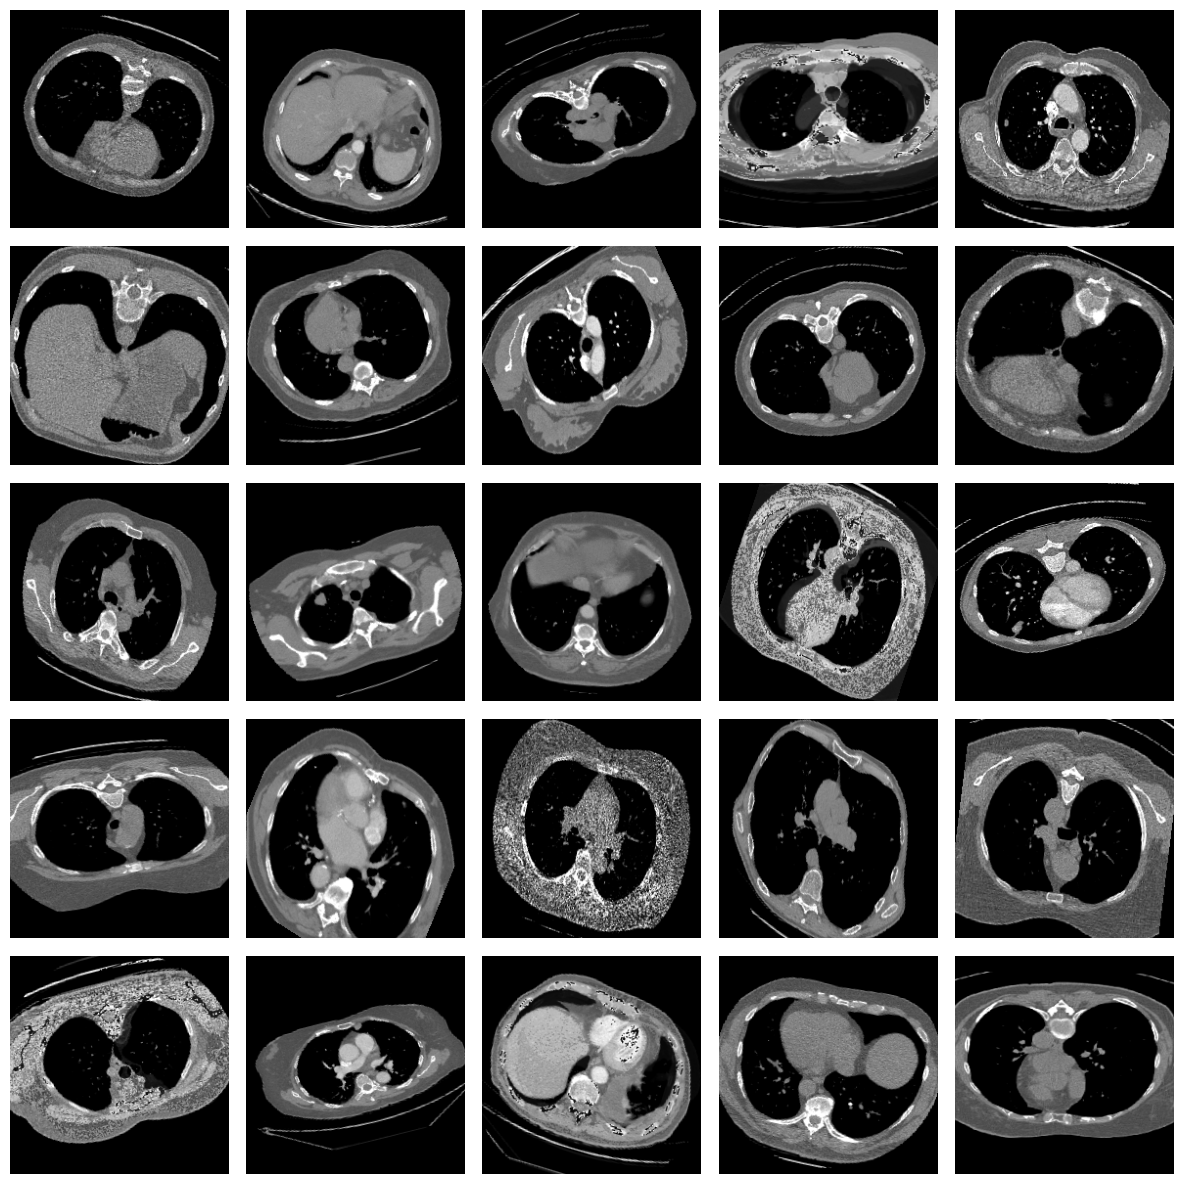

In [10]:
# Get one batch of augmented images
augmented_images, _ = next(train_generator)  # Ignore labels (_)

# Plot a 5x5 grid of augmented images
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.flatten()

for img, ax in zip(augmented_images[:25], axes):  # Take the first 25 images
    ax.imshow(img[:, :, 0], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [11]:
@dataclass
class Hyperparameters:
    # Model
    activation = "relu"
    # Training
    # noise_std: float = 0.05 # then try 0.1
    optimiser = tfk.optimizers.Adam
    learning_rate = 1e-4
    weight_decay = 1e-4
    regularization1 = tfk.regularizers.L1L2(l1=1e-5, l2=0)
    regularization2 = tfk.regularizers.L1L2(l1=0, l2=0)
    loss = tfk.losses.CategoricalCrossentropy(from_logits=False)
    epochs = 50
    ## Early stopping parameters
    es_patience = 10
    es_min_delta = 1e-2
    ## Learning rate schedule
    lr_patience = 5
    lr_decay_factor = 0.3
    lr_min_delta = 5e-2 
    min_lr = 1e-6

hp = Hyperparameters()

In [12]:
def build_model(hp: Hyperparameters,
                feature_extractor: tfk.applications):
    
    inputs = tfkl.Input((IMG_HEIGHT, IMG_WIDTH, 3))

    # x = tfkl.Rescaling(1./255)(inputs)
    # gn = tfkl.GaussianNoise(hp.noise_std)(x)
    # x = tfkl.Rescaling(255)(gn)

    backbone_output = feature_extractor(inputs)

    conv_layer = tfkl.Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same')(backbone_output) 
    max_pool_layer = tfkl.MaxPooling2D(pool_size=(2, 2))(conv_layer)
    flatten_layer = tfkl.Flatten()(max_pool_layer) 

    x = tfkl.Dropout(0.6)(flatten_layer)

    x = tfkl.Dense(1024, activation='relu')(x)
    x = tfkl.Dense(512, activation='relu')(x)
    x = tfkl.Dense(256, activation='relu')(x)
    #x = tfkl.Dense(128, activation='relu')(x)

    x = tfkl.Dropout(0.4)(x)

    output = tfkl.Dense(5, activation="softmax")(x)
    
    model = tfk.Model(inputs, output)
    return model

In [13]:
def fit(model: tfk.Model,
        train_generator: ImageDataGenerator,
        val_generator: ImageDataGenerator,
        hp: Hyperparameters):
    model.compile(loss=hp.loss,
                  optimizer=hp.optimiser(learning_rate=hp.learning_rate, weight_decay=hp.weight_decay), 
                  metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=hp.epochs,
        class_weight=class_weights,
        #validation_data=val_dataset,
        callbacks=[
            tfk.callbacks.EarlyStopping(monitor='val_loss', 
                                        #mode='min',
                                        patience=hp.es_patience, 
                                        restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(
                factor=hp.lr_decay_factor,
                patience=hp.lr_patience,
                min_delta=hp.lr_min_delta,
                min_lr=hp.min_lr,
                verbose=1,
            )
    ]
    
    ).history

    return model, history

In [14]:
backbone = tfk.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(IMG_HEIGHT,IMG_WIDTH,3),
    pooling=None #'avg'
)

backbone.trainable = False

model = build_model(hp, backbone)

model, history = fit(model, train_generator, val_generator, hp)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.1965 - loss: 2.7081 - val_accuracy: 0.3192 - val_loss: 1.5809 - learning_rate: 1.0000e-04
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 847ms/step - accuracy: 0.1987 - loss: 1.7808 - val_accuracy: 0.1480 - val_loss: 1.6718 - learning_rate: 1.0000e-04
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 844ms/step - accuracy: 0.2258 - loss: 1.7780 - val_accuracy: 0.2051 - val_loss: 1.6307 - learning_rate: 1.0000e-04
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 874ms/step - accuracy: 0.1727 - loss: 1.7965 - val_accuracy: 0.1903 - val_loss: 1.6038 - learning_rate: 1.0000e-04
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 873ms/step - accuracy: 0.2356 - loss: 1.6378 - val_accuracy: 0.1543 - val_loss: 1.6057 - learning_rate: 1.0000e-04
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.2255 - loss: 1.6201
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 876ms/step - accuracy: 0.2257 - los

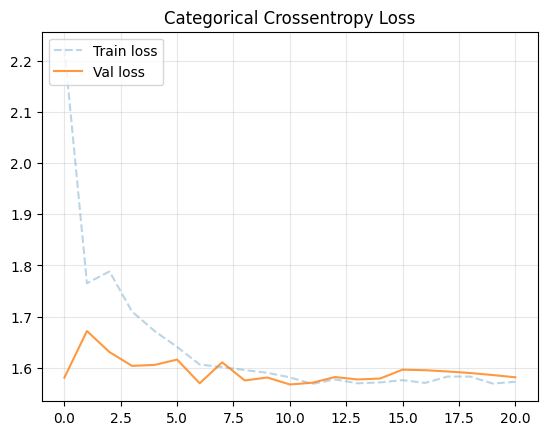

In [15]:
# Plot loss curves
plt.style.use('default')
plt.plot(history['loss'], label='Train loss', alpha=0.3, linestyle='--')
plt.plot(history['val_loss'], label='Val loss', alpha=0.8)
plt.title('Categorical Crossentropy Loss')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

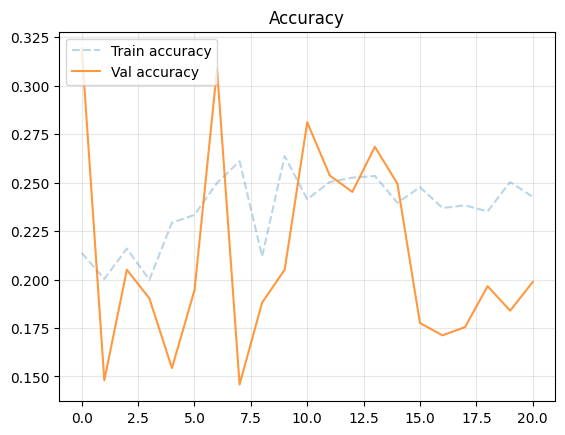

In [16]:
# Plot accuracy curves
plt.style.use('default')
plt.plot(history['accuracy'], label='Train accuracy', alpha=0.3, linestyle='--')
plt.plot(history['val_accuracy'], label='Val accuracy', alpha=0.8)
plt.title('Accuracy')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 706ms/step
Accuracy:  0.28


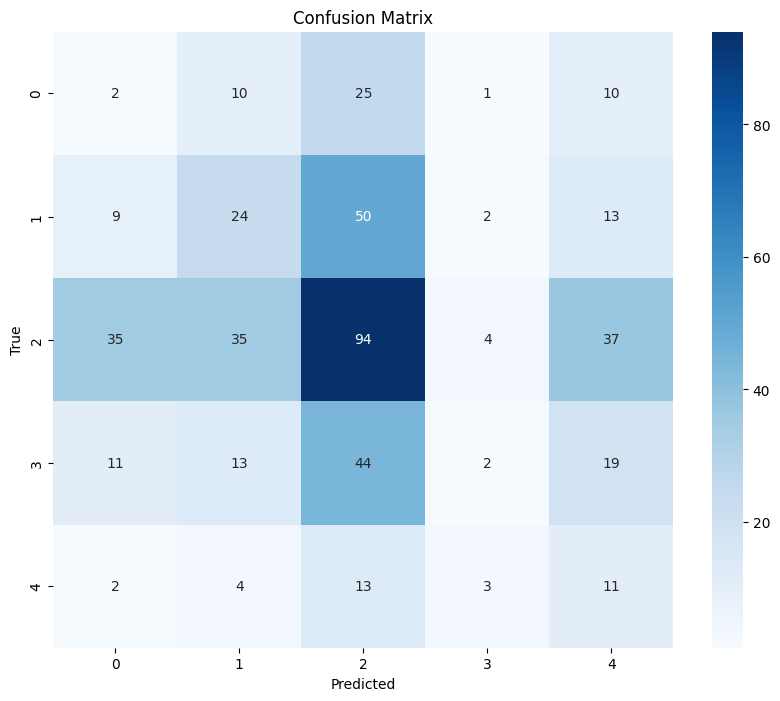

In [17]:
# Predict on validation data and plot confusion matrix
y_true = []
for _, labels in val_generator:
    y_true.extend(labels)
    if len(y_true) >= val_generator.samples:  # Stop when all samples are processed
        break
y_true = np.array(y_true)

if val_generator.class_mode == 'categorical':
    y_true = np.argmax(y_true, axis=1)  # Convert one-hot to class indices

y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices
print("Accuracy: ", round(accuracy_score(y_true, y_pred_classes), 2))

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
from sklearn.metrics import classification_report

# Compute classification report
report = classification_report(y_true, y_pred_classes, target_names=["0", "1", "2", "3", "4"], digits=2)

print(report)


              precision    recall  f1-score   support

           0       0.03      0.04      0.04        48
           1       0.28      0.24      0.26        98
           2       0.42      0.46      0.44       205
           3       0.17      0.02      0.04        89
           4       0.12      0.33      0.18        33

    accuracy                           0.28       473
   macro avg       0.20      0.22      0.19       473
weighted avg       0.28      0.28      0.27       473

